# Exploratory Notebook on Kaggle's PUGB Dataset

So I like games. And I like numbers. And I like results. 

I want to see what results we can get for gamers for what aspects of a game are beneficial for improving and winning. I'd like to really understand quantitatively the dynamics of team playing. As a healer, I know heals are just as important to winning as kills. So are solo players or small teams with little healing as likely to win as those without? Do they end up on top? Maybe in a game like PUGB but maybe not! 

### kaggle competition description: 

"In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)."
-https://www.kaggle.com/c/pubg-finish-placement-prediction/data?select=sample_submission_V2.csv

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
%matplotlib inline

# Training data
First load the training data and display given features.

In [2]:
train_data = pd.read_csv('data/train_V2.csv')

In [3]:
info={}
for c in train_data.columns:
    info[c] = train_data[c].dtype
    
print('%20s %10s' % ('name','type'))
print('%20s %10s' % ('----','----'))
for key,value in info.items():
    print('%20s  %10s' %(key,value))

                name       type
                ----       ----
                  Id      object
             groupId      object
             matchId      object
             assists       int64
              boosts       int64
         damageDealt     float64
               DBNOs       int64
       headshotKills       int64
               heals       int64
           killPlace       int64
          killPoints       int64
               kills       int64
         killStreaks       int64
         longestKill     float64
       matchDuration       int64
           matchType      object
            maxPlace       int64
           numGroups       int64
          rankPoints       int64
             revives       int64
        rideDistance     float64
           roadKills       int64
        swimDistance     float64
           teamKills       int64
     vehicleDestroys       int64
        walkDistance     float64
     weaponsAcquired       int64
           winPoints       int64
        winP

<AxesSubplot:>

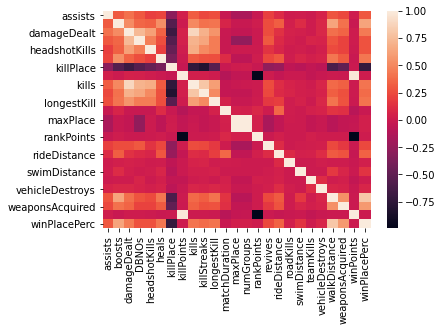

In [4]:
# setup seaborn heatmap of correlation matrix within specified sample
sns.heatmap(train_data.corr())

Each game of PUGB has up to 100 players and teams of up to size 4. However, whenever a player d/ces or otherwise loses connection and returns, she or he gets added uniquely again to the group and hence the match. First we check out which overcounts we have to see if there are any.

In [5]:
train_data['matchSize']= train_data.groupby(['matchId'])['matchId'].transform('count')
train_data['groupSize']= train_data.groupby(['groupId'])['groupId'].transform('count')

In [6]:
num_matches = len(train_data['matchId'].unique())
over100 = len(set(train_data[train_data['matchSize']>100]['matchId']))
print('percentage of matches with over 100 players: %2.1f%%' % (100*over100/num_matches))

percentage of matches with over 100 players: 0.0%


From what we just saw, 0 matches have over 100 players even though some games had duplicate entries for a player.

In [9]:
train_data['groupPerMatch'] = train_data['groupSize']/train_data['matchSize']

In [10]:
tgroup = list(set(train_data[train_data['groupPerMatch']>0.5]['matchId']))
print(len(tgroup))

train_data2 = train_data[~train_data['matchId'].isin(tgroup)]

460


So 460 matches had 1 group make up the majority of the game, so we cut those matches out.

In [11]:
train_data2.describe()
train_data=train_data2

## Derived data
Introduce some derived features using the given dataset.

In [12]:
groups_large = train_data[train_data['groupSize']>4]['groupId']
num_large = len(set(groups_large))
print('percentage of too large groups: %2.1f%%' % (100*num_large/len(set(train_data['groupId']))))

percentage of too large groups: 5.7%


In [13]:
gg_high = train_data[train_data['groupSize']>4].groupby('groupId').sum()
gg_low = train_data[train_data['groupSize']<=4].groupby('groupId').sum()

In [14]:
gg_high.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchSize,groupSize,groupPerMatch
count,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,...,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000,115085.000000
mean,0.982604,2.391945,516.582573,3.490107,0.768953,3.947143,396.385141,3411.186540,3.189860,2.246096,...,9.443843,0.172490,0.023539,3419.742039,16.936178,4032.316305,1.471717,595.770500,43.608941,0.467105
std,1.960125,3.766989,521.825108,3.754850,1.464704,6.762865,200.627400,4269.696995,4.775608,1.990991,...,60.576123,0.535511,0.165160,4137.854885,12.596706,5023.903361,1.319103,183.555147,34.053452,0.374538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,25.000000,0.250000
25%,0.000000,0.000000,247.970000,1.000000,0.000000,0.000000,258.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,590.240000,9.000000,0.000000,0.357000,480.000000,25.000000,0.263158
50%,0.000000,1.000000,428.400000,3.000000,0.000000,1.000000,357.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,1555.890000,15.000000,0.000000,1.154000,546.000000,36.000000,0.367347
75%,1.000000,3.000000,665.900000,5.000000,1.000000,5.000000,480.000000,6932.000000,4.000000,3.000000,...,0.000000,0.000000,0.000000,4885.300000,22.000000,7716.000000,2.333100,665.000000,49.000000,0.515789
max,63.000000,37.000000,14686.000000,114.000000,63.000000,135.000000,2418.000000,32647.000000,147.000000,35.000000,...,3823.000000,35.000000,4.000000,38909.000000,330.000000,40133.000000,13.713600,2883.000000,961.000000,10.333333


In [15]:
ggdiff = gg_high.mean() - gg_low.mean()
print(ggdiff)

assists               0.497818
boosts               -0.039551
damageDealt         243.943146
DBNOs                 2.169511
headshotKills         0.287554
heals                 0.997165
killPlace           309.526833
killPoints         2441.446850
kills                 1.230338
killStreaks           1.115606
longestKill           9.743641
matchDuration      6844.112347
maxPlace             88.238858
numGroups            84.060060
rankPoints         3517.275083
revives               0.349949
rideDistance        329.838509
roadKills             0.002312
swimDistance         -0.478282
teamKills             0.127404
vehicleDestroys       0.006531
walkDistance        939.821255
weaponsAcquired       9.456351
winPoints          2863.915952
winPlacePerc          0.460534
matchSize           412.520567
groupSize            38.840321
groupPerMatch         0.416110
dtype: float64


### individual data

In [ ]:
train_data['travelDistance']     = train_data['rideDistance']+train_data['walkDistance'] + train_data['swimDistance']
train_data['headshotRate']       = train_data['headshotKills']/train_data['kills']
train_data['killsPerWeapon']     = train_data['kills']/train_data['weaponsAcquired']
train_data['weaponsPerDistance'] = train_data['weaponsAcquired']/train_data['travelDistance']
train_data['healsPerDistance']   = train_data['heals']/train_data['travelDistance']
train_data['boostsPerDistance']  = train_data['boosts']/train_data['travelDistance']
train_data['killsPerGroup']= train_data['kills']/train_data['groupSize']

# Separating match types
Matches are campaigns of squads, solo, or duo, and in each campaign the game style is first- or third-person perspective (fpp or tpp). Squads are of only 4 players max, but in some instances a person d/ced or otherwise left the game and rejoined, only to be double counted (and with a unique id at each entry), so for some cases the squad numbers are overcounts.

* Can we tell if an entry in a squad is a duplicate? (Would depend on how far into the game the d/c occurred.)

## Learning how FPP/TPP affects gameplay
Perspective is key to gameplay. People typically specialize in a set of conditions for a game, whether it be a bow-user in Hades, a sniper in Fortnite, etc. 

In this dataset, two types of gameplay beyond solo/duo/squard are used:
* tpp - third-person perspective is the base gameplay
* fpp - first-person perspective.


With this dataset, we cannot follow a player's progression. With each match the player IDs as well as group IDs are created anew, so there is no following either a player or team, so we cannot see if one player chooses one format or another.

In [18]:
match_types=[]
for l in train_data['matchType'].unique():
    match_types.append(l)
print(match_types)

['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo', 'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp', 'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad', 'crashtpp', 'normal-solo']


In [19]:
fpp_match = ['squad-fpp', 'solo-fpp','duo-fpp','normal-squad-fpp','crashfpp','normal-solo-fpp','flarefpp','normal-duo-fpp']
tpp_match = ['duo','squad','solo','flaretpp','normal-duo','crashtpp']

squad_match =['squad-fpp','squad','normal-squad-fpp','normal-squad']
solo_match = [i.replace('squad','solo') for i in squad_match]
duo_match = [i.replace('squad','duo') for i in squad_match] 

def match_pp(match):
    if match in fpp_match:
        return 'fpp'
    else:
        return 'tpp'
def match_campaign(match):
    if match in squad_match:
        return 'squad'
    elif match in duo_match:
        return 'duo'
    else:
        return 'solo'

In [20]:
train_data['pp'] = train_data['matchType'].apply(match_pp)
train_data['campaign'] = train_data['matchType'].apply(match_campaign)

<ipython-input-20-5b1c200e5bb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pp'] = train_data['matchType'].apply(match_pp)
<ipython-input-20-5b1c200e5bb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['campaign'] = train_data['matchType'].apply(match_campaign)


In [21]:
cols = (train_data.columns).tolist()
agg_cols = []
# obtain the numerical data
for c in cols:
    if c not in set(['Id', 'matchId','groupId','matchType']):
        agg_cols.append(c)

#content=[]
#for a in agg_cols:
#    if max(train_data[a]) > 0 and train_data[a].mean()/max(train_data[a]) > 0.01 and a != 'rankPoints':
#        content.append(a)


In [22]:
pp_df       = train_data.groupby('pp')#.sort_values('damageDealt', ascending=False)
campaign_df = train_data.groupby('campaign')#.sort_values('damageDealt', ascending=False)

In [23]:
fpp_df = train_data[train_data['pp'] == 'fpp']
tpp_df = train_data[train_data['pp'] == 'tpp']

In [24]:
squad_df = train_data[train_data['campaign'] == 'squad']
solo_df  = train_data[train_data['campaign'] == 'duo']
duo_df   = train_data[train_data['campaign'] == 'solo']


In [25]:
groups_df=train_data.groupby('groupId')[agg_cols].sum().sort_values('damageDealt', ascending=False)

# Checking out relationship between features

In [26]:
var1 = ['boosts','damageDealt','DBNOs','kills','weaponsAcquired','travelDistance']
var2 = ['heals','DBNOs','revives','kills','weaponsAcquired','travelDistance']
var3 = ['boosts','heals','assists','revives','kills','headShotRate']
var4 = ['boosts','heals','DBNOs','revives','kills','travelDistance']
var5 = ['headShotRate','killsPerWeapon','walkDistance','rideDistance','roadKills']
selected_vars=list(set(var1+var2+var3+var4+var5))

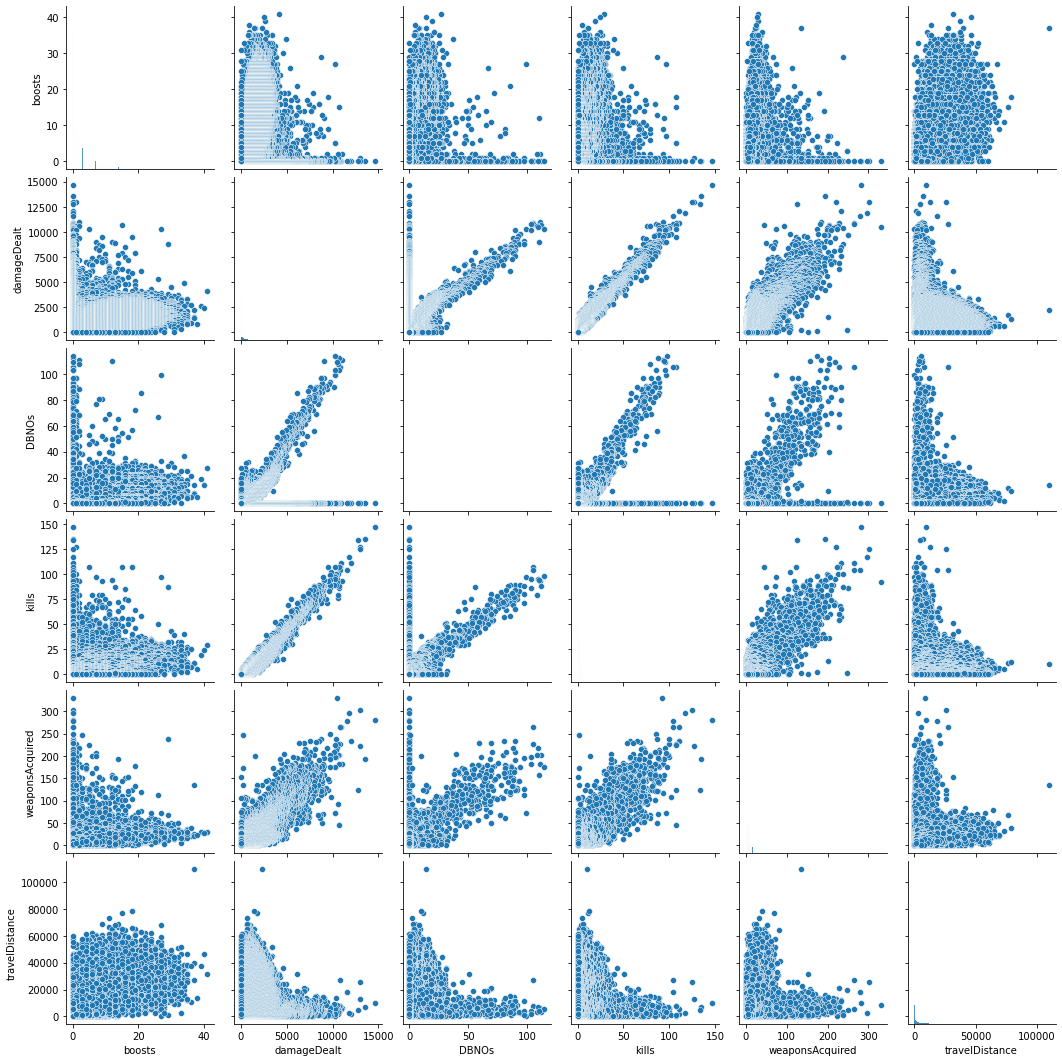

In [27]:
sns.pairplot(data=groups_df[var1])

Nice clear linear relationship between damage dealt ('damageDealt') and kills ('kills') and even knocks ('DBNOs', referring to players put into inaction but not killed). 

Interestingly, it seems like the majority of weapons are acquired where players land, and furthermore those that acquire a ton might not travel as much. We see this from the left-most column showing the relationship of travelDistance with the other variables, notably weaponsAcquired. Moreover, the majority of kills and knocks happen with little travel (hence players getting right into the action).

In [28]:
# plot seaborn heatmap of correlation matrix
def sns_heatmap(df,title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(dpi=180)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)

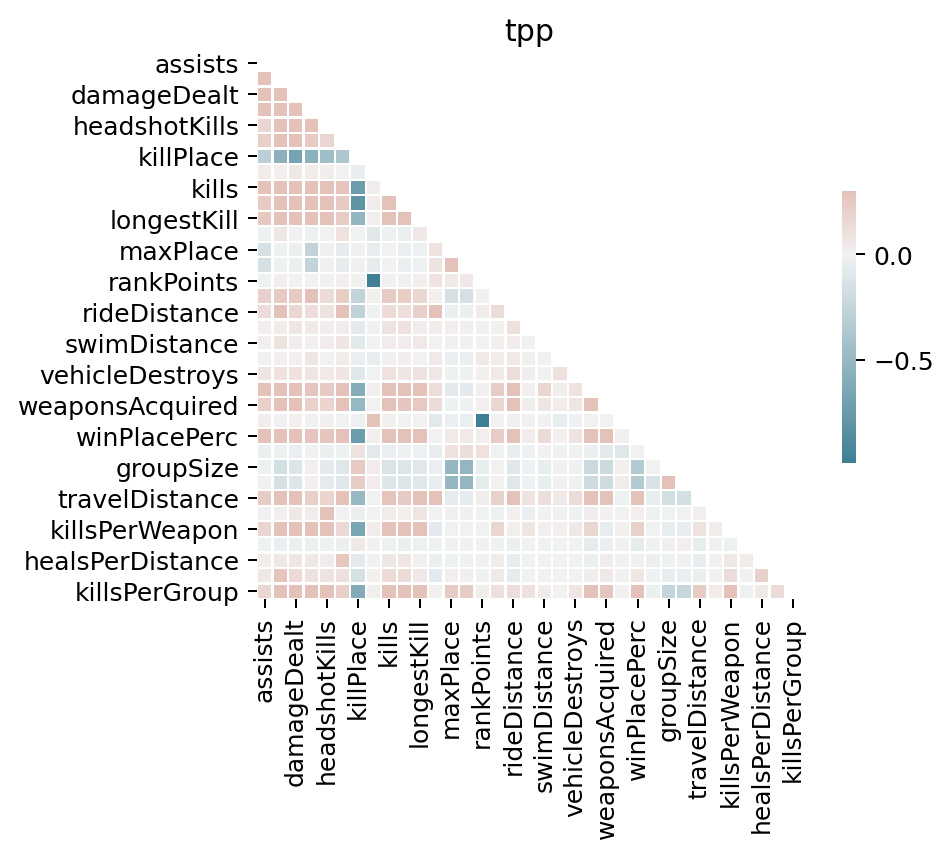

In [29]:
sns_heatmap(tpp_df,'tpp')    

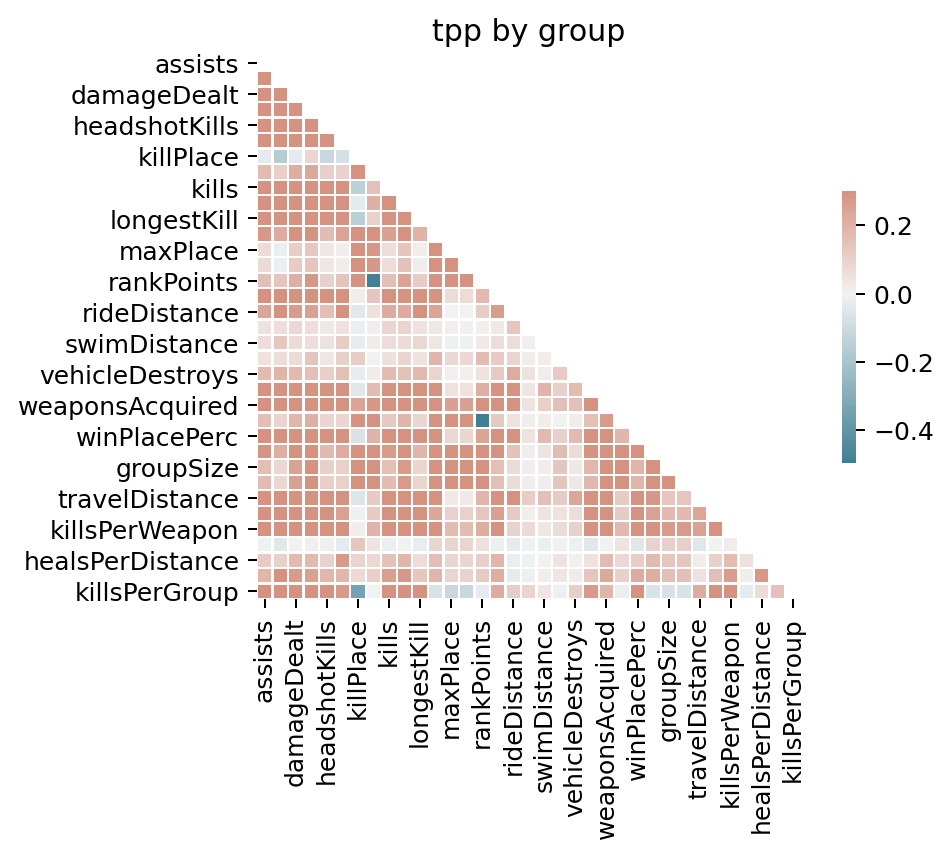

In [30]:
sns_heatmap(tpp_df.groupby('groupId')[agg_cols].sum().sort_values('damageDealt', ascending=False),'tpp by group')

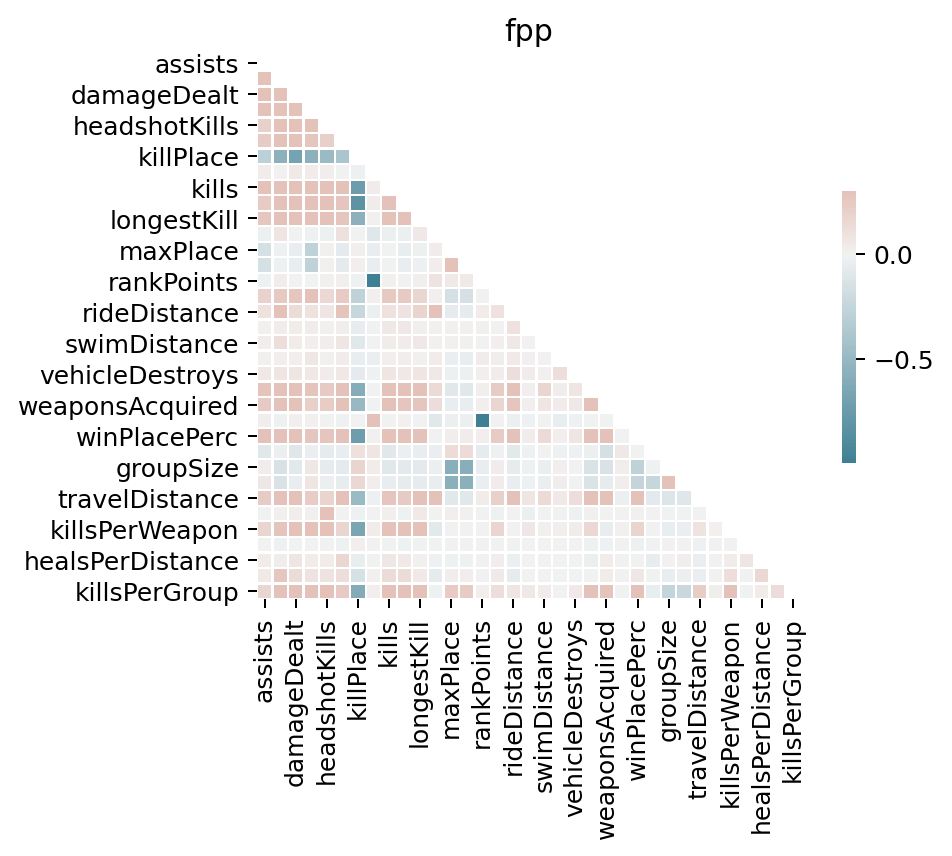

In [31]:
sns_heatmap(fpp_df,'fpp')

Largely the same results when seeing tpp v fpp..

In [32]:
sns_heatmap(squad_df[selected_vars],'squads')
sns_heatmap(duo_df[selected_vars],'duo')
sns_heatmap(solo_df[selected_vars],'solo')

KeyError: "['headShotRate'] not in index"

In [ ]:
sns.pairplot(data=tpp_df[var4])

In [ ]:
match_agg = train_data.groupby('matchId')[agg_cols].sum()
mg = match_agg.reset_index()#.apply(lambda x: x.sort_values(ascending=False)).reset_index()
mg.sort_values('weaponsAcquired', ascending=False)

In [ ]:
def plot_hist(df, col,perc):
    '''
    Plot histogram of pandas dataframe df
    column col
    with bins sized by percentage perc of the values of col'''
    df.hist(col,bins=int(sum(df[col])/(df[col].max()-df[col].min())*perc))

In [ ]:
plot_hist(mg,'travelDistance',0.25)


We see we have a bimodal distribution with some outliers (travelDistance > 800000...?). 
stackoverflow has helpful discussions on finding and removing outliers here https://stackoverflow.com/a/22357811. At the end of the day, quantiles are important numbers to know. We use the median absolute deviation so that our results aren't dependant on the data size.

There are different wasy to compute quantiles and particularly a median by weighing each value differently. The conventional median places a weight of 1 on each value and hence is found by, say, sorting an array and taking the middle element. That's not too helpful though when you have data such as above with a clear bimodal distribution. To handle that, we use the median to split the data in two components, calculate the medians for them separately, and consider the cut-off of the two datasets alone.

Further, we use the Harrell-Davis method to compute the median. It is done in scipy where quartiles for the quarter, half, and third-quarter are returned; we use only the half (the median) for our data.

tl;dr:
* bimodal data set => use a double-ended outlier method
* results independent of data size => median absolute deviation
* Harrell-Davis median => weighted method to capture an arguably more accurate range of ok values

In [ ]:
#
def compute_median(x, name = 'standard'):
    if name == 'hd':
        return stats.mstats.hdquantiles(x,prob=[0.5])[0]
    else:
        return np.median(x,axis=0)
    

def mad_outlier(x, thresh=3):
    if len(x.shape) == 1:
        x = x[:,np.newaxis]
    median = np.median(x,axis=0)
    diff = np.sum((x - median)**2,axis=-1)
    diff = np.sqrt(diff)
    mad = np.median(diff)

    modified_z_score = 0.6745 * diff / mad

    return x[modified_z_score > thresh]


def double_outlier(x, thresh=3):
    # assuming x is sorted!
    if len(x.shape) == 1:
        x = x[:,np.newaxis]

    median = compute_median(x,'hd')

    x_low  = x[x<=median]
    x_high = x[x>median]
    
    x_low  = x_low.reshape(-1,1)
    x_high = x_high.reshape(-1,1)
    
    med_low  = compute_median(x_low,'hd')
    med_high = compute_median(x_high,'hd')
    
    
    d_low = np.sum((x_low - med_low)**2,axis=-1)
    d_low = np.sqrt(d_low)
    
    d_high = np.sum((x_high - med_high)**2,axis=-1)
    d_high = np.sqrt(d_high)
    
    mad_low  = np.median(d_low)
    mad_high = np.median(d_high)
    
    thresh_low  = ((median-med_low)/mad_low)*thresh
    thresh_high = ((med_high-median)/mad_high)*thresh
    
    # if either is 0, then no outlier
    if thresh_low == 0:
        thresh_low = sys.maxint
    if thresh_high == 0:
        thresh_high = sys.maxint
    

    mod_z_low  = 0.6745 * d_low / mad_low
    mod_z_high = 0.6745 * d_high / mad_high
    
    out_low  = list(mod_z_low  > thresh_low)
    out_high = list(mod_z_high > thresh_high)

    outliers = out_low+out_high

    return x[outliers] 

def plot(x):
    fig, ax = plt.subplots(nrows=1)
    x=np.sort(x)
    sns.distplot(x, ax=ax, rug=True, hist=True)
    outliers = double_outlier(x,3)
    outliers=outliers.flatten()
    ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    ax.set_title('MAD-based Outliers', **kwargs)
    return outliers

In [ ]:
outliers = plot(mg['travelDistance'].values)
mg2 = mg[~mg['travelDistance'].isin(outliers)]

In [ ]:
mg2['travelDistance'].hist()

In [ ]:
p2p=['heals','DBNOs','revives','kills','weaponsAcquired','travelDistance']
sns.pairplot(data=mg2[p2p])

Exploring a subset of the data.

In [ ]:
# setup seaborn heatmap of correlation matrix within specified sample
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The above correlation matrix if anything is honestly just nice to see all the variables together. Lets see if we can derive more features that are more indicative of success.

In [ ]:
df['headshotRate']= df['headshotKills']/df['kills']
df['killsPerWeapon']= df['kills']/df['weaponsAcquired']
df['weaponsPerDistance']=df['weaponsAcquired']/df['travelDistance']

In [ ]:
# setup seaborn heatmap of correlation matrix within specified sample
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# unused code: create unique player and group ids for each match, 
# so cannot track progress of specific players
'''
# FUNCTION: show_overlap(df1, df2, on_cols, desc)
# INPUT: dataframe df1, dataframe df2, list of column names on_cols, string description desc
# OUTPUT: no return, only print statement of number of rows in merged dataframe
# description: function to show overlap between two dataframes
# what it does: merge two dataframes on the columns on_cols to see overlap         
def show_overlap(df1, df2, on_cols, desc):
    print('show overlap for ' + desc + '......')
    merged = pd.merge(df1,df2, on=on_cols, how='inner')
    print('number of fpp and tpp players: ' + str(len(merged)) + '\n')
    
fpp_train = train_data[squad_fpp | duo_fpp | solo_fpp]
    
solo_fpp_df = train_data[solo_fpp]
solo_df    = train_data[solo]

duo_fpp_df = train_data[duo_fpp]
duo_df    = train_data[duo]

squad_fpp_df = train_data[squad_fpp]
squad_df    = train_data[squad]


show_overlap2(solo_fpp_df, solo_df,['Id'], 'solo') 
show_overlap2(duo_fpp_df, duo_df,['Id'], 'duo') 
show_overlap2(squad_fpp_df, squad_df,['Id'], 'squad') 
'''